# Figures for my talk

In [1]:
import pathlib
import sys
import copy

import aiapy
import asdf
import astropy.units as u
import astropy.table
import sunpy.map
import eispac.core
import matplotlib.pyplot as plt
import numpy as np

from astropy.coordinates import SkyCoord
from sunpy.coordinates import propagate_with_solar_surface, Helioprojective, get_horizons_coord

from sunpy.net import attrs as a, Fido

sys.path.append('../scripts/')
import colormaps

In [19]:
# Adjust this as needed
root_dir = pathlib.Path('../../sphere-workshop-2024-talk/')  # change this to mounted disk
data_dir = pathlib.Path('../data/')  # pathlib.Path('/Volumes/My Passport for Mac/loops_workshop_2024/data')
figure_dir = root_dir / 'figures'

In [3]:
ar_table = astropy.table.QTable.read(data_dir / 'tables' / 'mason_ars_region_1.asdf')

In [4]:
ar_table

<QTable length=3>
NOAA AR ...           XRT file          
        ...                             
 int64  ...            str28            
------- ... ----------------------------
  11944 ...                             
  11967 ... L1_XRT20140203_110221.2.fits
  11990 ... L1_XRT20140302_000009.0.fits

Load time lag data

In [5]:
max_cc_threshold = 0.25
tl_maps_aia = []
tl_maps_eis = []
cc_maps_aia = []
cc_maps_eis = []
for row in ar_table:
    # Time lags
    tl_dir = data_dir / f'noaa_{row["NOAA AR"]}' / 'diagnostics' / 'time_lag'
    cc_dir = data_dir / f'noaa_{row["NOAA AR"]}' / 'diagnostics' / 'max_cc'
    # AIA FOV
    cc_maps = sunpy.map.Map(sorted(cc_dir.glob(f'maxcc_noaa{row["NOAA AR"]}_fovAIA_*.fits')))
    cc_maps_aia.append({f'{m.meta["chan_a"]}_{m.meta["chan_b"]}': m for m in cc_maps})
    tl_maps = sunpy.map.Map(sorted(tl_dir.glob(f'timelag_noaa{row["NOAA AR"]}_fovAIA_*.fits')))
    for mcc,mtl in zip(cc_maps,tl_maps):
        mtl.mask = mcc.data < max_cc_threshold 
    tl_maps_aia.append({f'{m.meta["chan_a"]}_{m.meta["chan_b"]}': m for m in tl_maps})
    # EIS FOV    
    cc_maps = sunpy.map.Map(sorted(cc_dir.glob(f'maxcc_noaa{row["NOAA AR"]}_fovEIS_*.fits')))
    cc_maps_eis.append({f'{m.meta["chan_a"]}_{m.meta["chan_b"]}': m for m in cc_maps})
    tl_maps = sunpy.map.Map(sorted(tl_dir.glob(f'timelag_noaa{row["NOAA AR"]}_fovEIS_*.fits')))
    for mcc,mtl in zip(cc_maps,tl_maps):
        mtl.mask = mcc.data < max_cc_threshold 
    tl_maps_eis.append({f'{m.meta["chan_a"]}_{m.meta["chan_b"]}': m for m in tl_maps})

Load EM slope data

In [7]:
em_slopes_eis = []
em_slopes_aia = []
em_slopes_aia_eis_fov = []
for row in ar_table:
    dem_dir = data_dir / f'noaa_{row["NOAA AR"]}' / 'diagnostics' / 'dem'
    with asdf.open(dem_dir / f'emslope_noaa{row["NOAA AR"]}_eis.asdf', lazy_load=False, copy_arrays=True) as af:
        sm = af['slope_map']
        em_slopes_eis.append(sm)
    with asdf.open(dem_dir / f'emslope_noaa{row["NOAA AR"]}_fovAIA.asdf', lazy_load=False, copy_arrays=True) as af:
        sm = af['slope_map']
        em_slopes_aia.append(sm)
    with asdf.open(dem_dir / f'emslope_noaa{row["NOAA AR"]}_fovEIS.asdf', lazy_load=False, copy_arrays=True) as af:
        sm = af['slope_map']
        em_slopes_aia_eis_fov.append(sm)

Make flare masks

In [41]:
tl_131_flare_threshold = -2500
mask_pairs = (('211_131', '193_131'))
flare_masks_aia = [np.any([np.all([v.data < tl_131_flare_threshold, ~v.mask], axis=0) for k,v in tlma.items() if k in mask_pairs],axis=0)
                   for tlma in tl_maps_aia]
flare_masks_eis = [np.any([np.all([v.data < tl_131_flare_threshold, ~v.mask], axis=0) for k,v in tlma.items() if k in mask_pairs],axis=0)
                   for tlma in tl_maps_eis]

## AR Reference Figure

In [13]:
channel_list = ['94','131','171','193','211','335']
aia_cutouts = []
for row in ar_table:
    _md = {}
    for channel in channel_list:
        files = sorted((data_dir / f'noaa_{row["NOAA AR"]}' / 'AIA' / 'level_2').glob(f'aia.lev2_euv_12s.*.{channel}.image.fits'))
        _md[channel] = sunpy.map.Map(files[len(files)//2])
    aia_cutouts.append(_md)

In [8]:
eis_maps_fe12 = sunpy.map.Map(
    [sorted((data_dir / f'noaa_{r["NOAA AR"]}' / 'EIS' / 'level_2.5').glob('eis_*.fe_12_195_119.2c-0.int.fits'))
     for r in ar_table]
)
eis_maps_fe16 = sunpy.map.Map(
    [sorted((data_dir / f'noaa_{r["NOAA AR"]}' / 'EIS' / 'level_2.5').glob('eis_*.fe_16_262_984.1c-0.int.fits'))
     for r in ar_table]
)

In [10]:
time_query = a.AttrOr(
    [a.Time(r['Date start'],end=r['Date end'],near=m.date_average) for r,m in zip(ar_table, eis_maps_fe12)]
)
q = Fido.search(
    time_query,
    a.Instrument.aia,
    a.Wavelength(171*u.AA),
)

files = Fido.fetch(q, path='../data/full_disk_context')
aia_maps_fd = sunpy.map.Map(files)  # sunpy.map.Map(sorted(data_dir.glob('aia_lev1_171a_*.fits')))

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

aia.lev1.171A_2014_02_03T10_33_23.34Z.image_lev1.fits:   0%|          | 0.00/12.4M [00:00<?, ?B/s]

aia.lev1.171A_2014_01_08T10_59_23.34Z.image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia.lev1.171A_2014_03_02T00_20_13.41Z.image_lev1.fits:   0%|          | 0.00/10.5M [00:00<?, ?B/s]

In [ ]:
#observer_locs = [get_horizons_coord('SDO', time=r['Date mid']) for r in ar_table]

INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spacecraft) (-136395) [sunpy.coordinates.ephemeris]


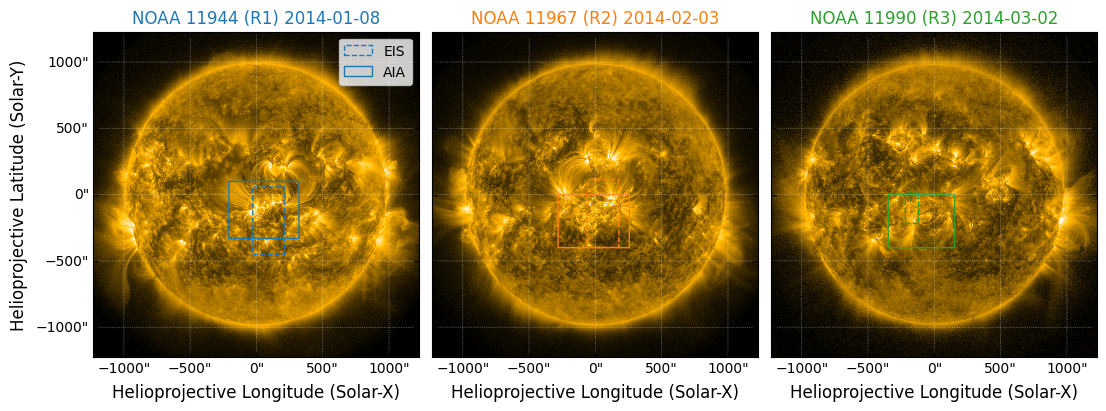

In [20]:
fig = plt.figure(figsize=(11,4),layout='constrained')
for i,(row,am,em) in enumerate(zip(ar_table,aia_maps_fd,eis_maps_fe12)):
    ax = fig.add_subplot(1,3,i+1,projection=am)
    am.plot(axes=ax, clip_interval=(1,99.99)*u.percent)
    # EIS FOV
    with propagate_with_solar_surface():
        eis_blc = em.bottom_left_coord.transform_to(am.coordinate_frame)
        eis_trc = em.top_right_coord.transform_to(am.coordinate_frame)
        am.draw_quadrangle(eis_blc,
                           top_right=eis_trc,
                           edgecolor=f'C{i}',
                           ls='--',
                           label='EIS')
    # AIA FOV
    frame = Helioprojective(observer=get_horizons_coord('SDO', time=row['Date mid']))
    blc = SkyCoord(*row['bottom left'], frame=frame)
    trc = SkyCoord(*row['top right'], frame=frame)
    with propagate_with_solar_surface():
        am.draw_quadrangle(
            blc.transform_to(am.coordinate_frame),
            top_right=trc.transform_to(am.coordinate_frame),
            edgecolor=f'C{i}',
            ls='-',
            label='AIA',
        )
    ax.coords[1].set_auto_axislabel(False)
    ax.label_outer()
    if i > 0:
        ax.coords[1].set_ticklabel_visible(False)
    if i == 0:
        ax.legend(frameon=True)
    title_date = am.date.datetime
    ax.set_title(f'NOAA {row["NOAA AR"]} (R{i+1}) {title_date.strftime("%Y-%m-%d")}', color=f'C{i}')
fig.savefig(figure_dir/'aia_context.pdf')

## AIA Images

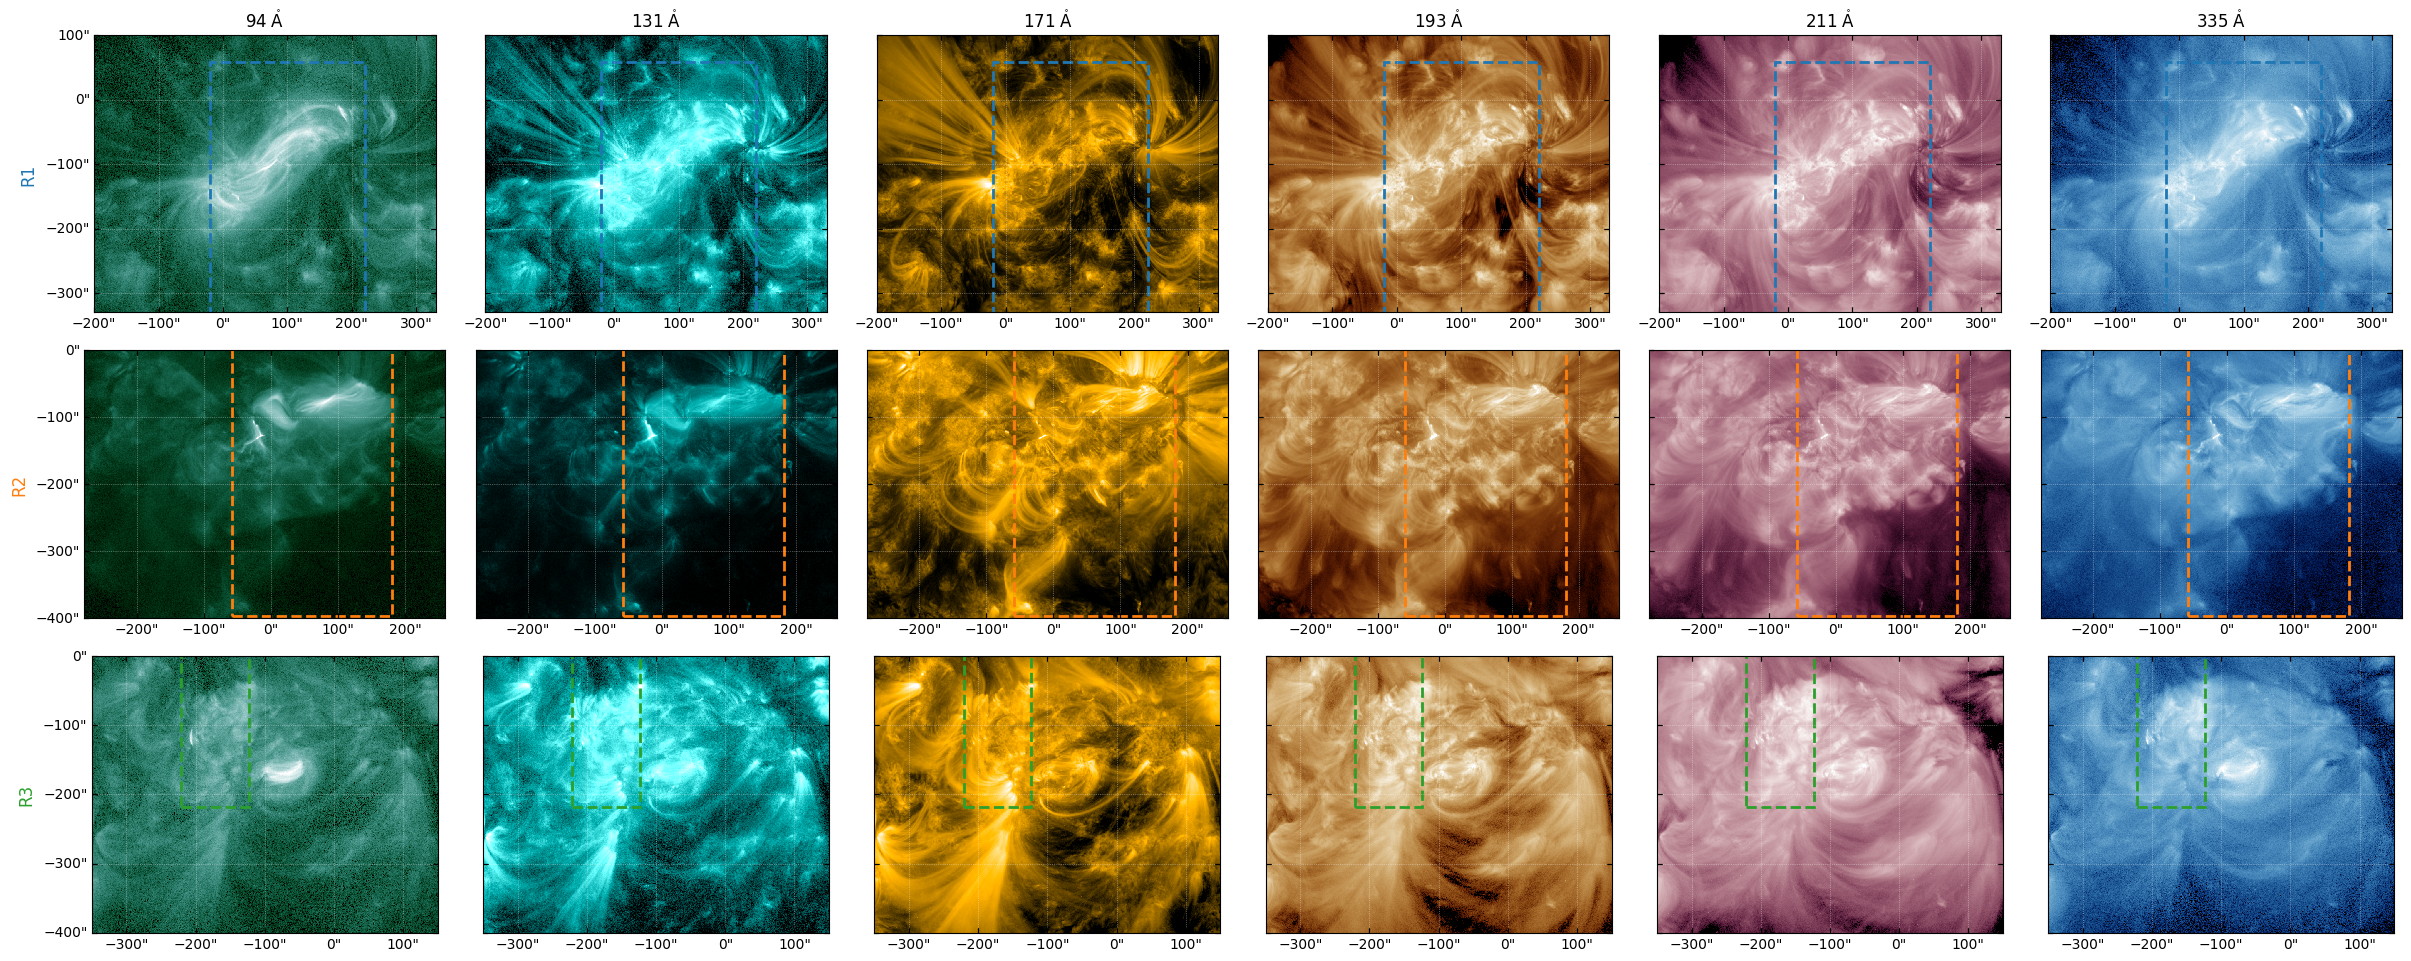

In [21]:
fig = plt.figure(figsize=(24,9.5),layout='constrained')
for i, (row,em) in enumerate(zip(ar_table,eis_maps_fe12)):
    for j,key in enumerate(channel_list):
        _m = aia_cutouts[i][key]
        ax = fig.add_subplot(len(aia_cutouts),len(aia_cutouts[i]),i*len(channel_list)+j+1,projection=_m)
        _m.plot(axes=ax, annotate=False, clip_interval=(1,99.99)*u.percent)
        # EIS FOV
        with propagate_with_solar_surface():
            eis_blc = em.bottom_left_coord.transform_to(_m.coordinate_frame)
            eis_trc = em.top_right_coord.transform_to(_m.coordinate_frame)
            am.draw_quadrangle(eis_blc,
                               top_right=eis_trc,
                               edgecolor=f'C{i}',
                               ls='--',
                               lw=2,
                               label='EIS')
        # Labeling
        ax.coords[0].set_auto_axislabel(False)
        ax.coords[1].set_auto_axislabel(False)
        if j > 0:
            ax.coords[1].set_ticklabel_visible(False)
        else:
            ax.coords[1].set_axislabel(f'R{i+1}', color=f'C{i}')
        if i == 0:
            ax.set_title(f'{_m.wavelength:latex_inline}')
fig.savefig(figure_dir / 'aia_cutouts.pdf')

## EIS Intensity Figures

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


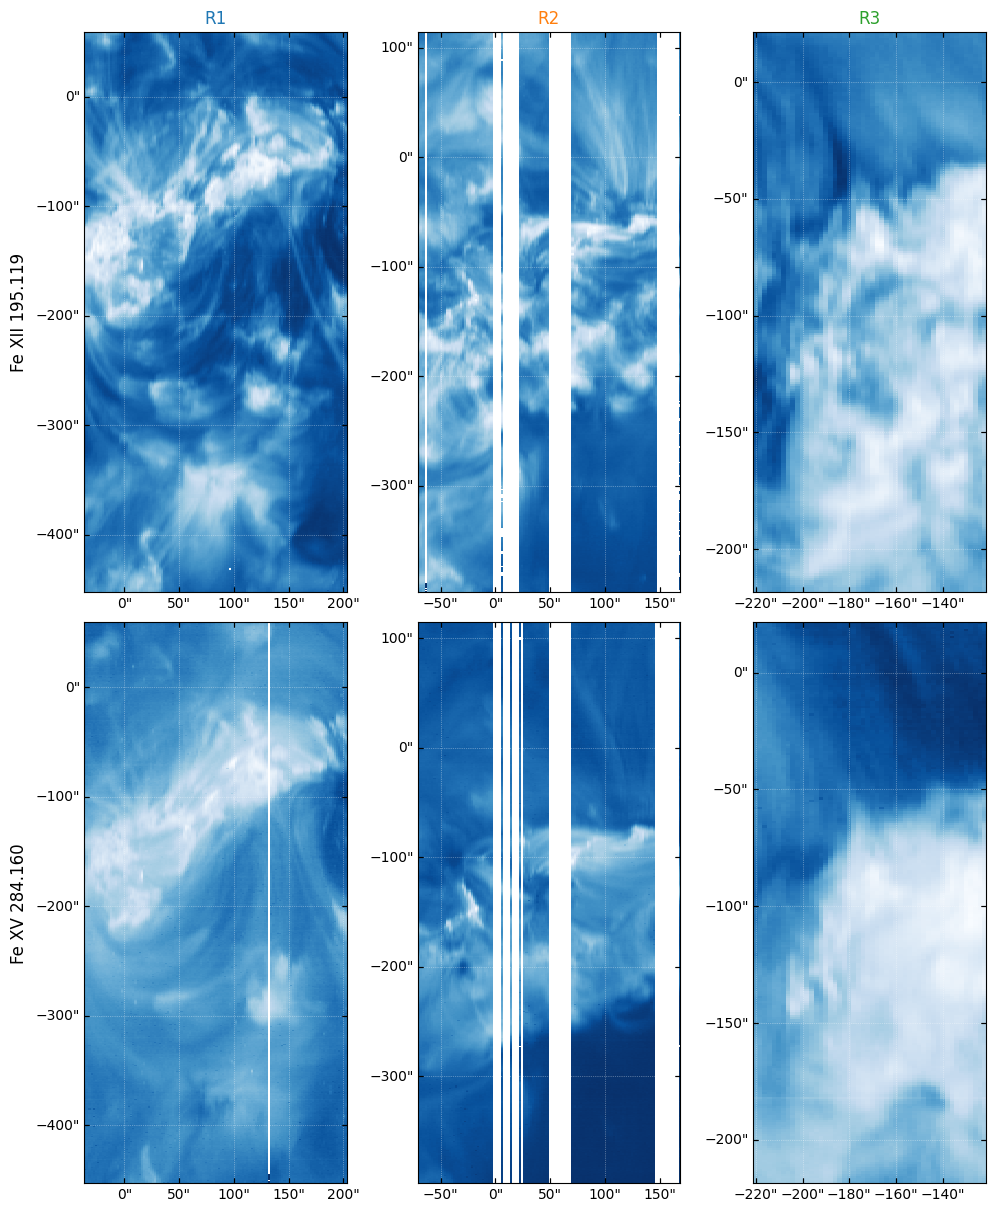

In [52]:
fig = plt.figure(figsize=(10,12),layout='constrained')
for i,row in enumerate(ar_table):
    # Fe 12
    _m = eis_maps_fe12[i]
    _m.mask = _m.data == 0.0
    ax = fig.add_subplot(2,len(ar_table),i+1,projection=_m)
    _m.plot(axes=ax,annotate=False)
    ax.coords[0].set_auto_axislabel(False)
    ax.coords[1].set_auto_axislabel(False)
    ax.set_title(f'R{i+1}', color=f'C{i}')
    if i == 0:
        ax.coords[1].set_axislabel(_m.meta['line_id'])
    # Fe 15
    _m = eis_maps_fe15[i]
    _m.mask = _m.data == 0.0
    ax = fig.add_subplot(2,len(ar_table),i+4,projection=_m)
    _m.plot(axes=ax,annotate=False)
    ax.coords[0].set_auto_axislabel(False)
    ax.coords[1].set_auto_axislabel(False)
    if i == 0:
        ax.coords[1].set_axislabel(_m.meta['line_id'])
fig.savefig(figure_dir / 'eis_rasters.pdf')

## Flare Masking

Show one time lag map and an image with a mask

In [53]:
m_aia_cutout = sunpy.map.Map(data_dir / 'noaa_11944' / 'AIA' / 'level_2' / 'aia.lev2_euv_12s.2014-01-08T120001Z.94.image.fits')
m_aia_cutout.mask = flare_masks_aia[0]

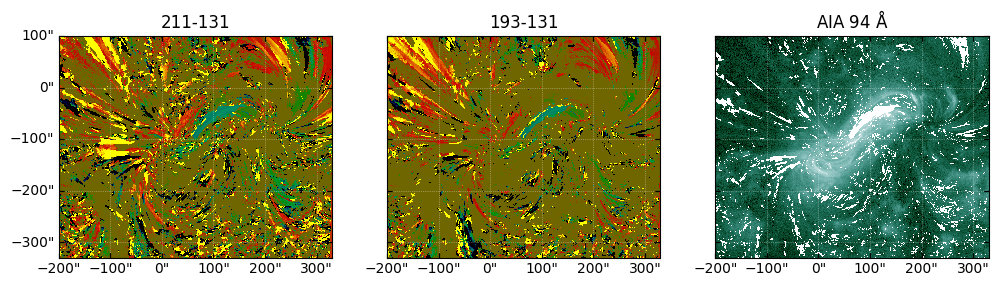

In [61]:
fig = plt.figure(figsize=(12,4))

for i,key in enumerate(mask_pairs):
    m_tl = copy.deepcopy(tl_maps_aia[0][key])
    m_tl.mask = None
    
    ax = fig.add_subplot(1,3,i+1,projection=m_tl)
    m_tl.plot(axes=ax,cmap='idl_bgry_004',vmin=-7200,vmax=7200, annotate=False)
    ax.coords[1].set_auto_axislabel(False)
    ax.coords[0].set_auto_axislabel(False)
    ax.set_title('-'.join(key.split('_')))
    ax.label_outer()
    if i>0:
        ax.coords[1].set_ticklabel_visible(False)

ax = fig.add_subplot(133,projection=m_aia_cutout)
m_aia_cutout.plot(axes=ax,clip_interval=(1,99.999)*u.percent,annotate=False)
ax.coords[1].set_auto_axislabel(False)
ax.coords[0].set_auto_axislabel(False)
ax.set_title(f'AIA {m_aia_cutout.wavelength.to_value(u.AA):.0f}' + r' $\mathrm{\AA}$');
ax.label_outer()
ax.coords[1].set_ticklabel_visible(False)

fig.savefig(figure_dir / 'time_lag_mask.pdf')

## EM Slope Maps

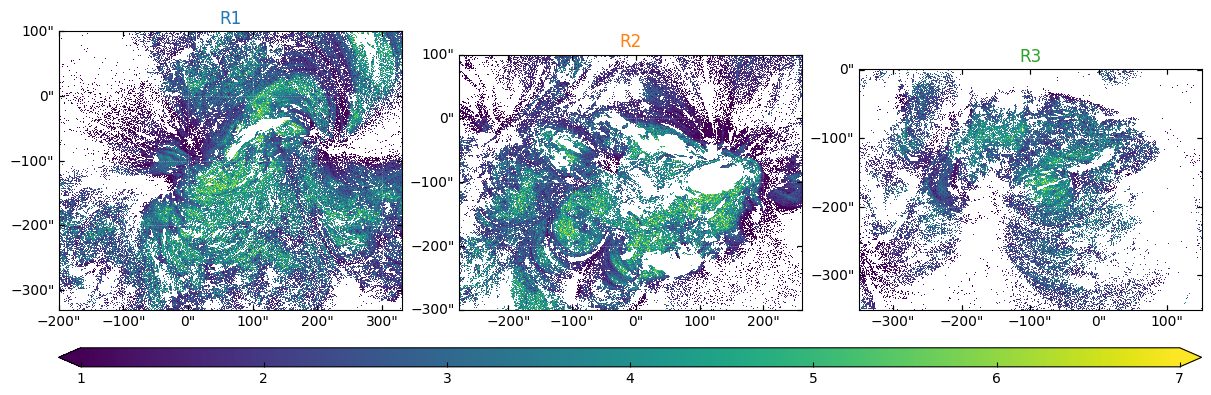

In [62]:
fig = plt.figure(figsize=(12,4),layout='constrained')
axes = []
for i,sm in enumerate(em_slopes_aia):
    _sm = copy.deepcopy(sm)
    _sm.mask = np.any([_sm.mask, flare_masks_aia[i]],axis=0)
    ax = fig.add_subplot(1,len(em_slopes_aia),i+1,projection=_sm)
    im = _sm.plot(axes=ax, vmin=1, vmax=7, cmap='viridis',annotate=False)
    ax.label_outer()
    ax.coords[0].set_auto_axislabel(False)
    ax.coords[1].set_auto_axislabel(False)
    ax.set_title(f'R{i+1}',color=f'C{i}')
    axes.append(ax)
axes = np.array(axes)
fig.colorbar(im,
             ax=axes,
             fraction=1,
             extend='both',
             orientation='horizontal',
             location='bottom',
             aspect=60,
             pad=0.02,
             extendfrac=0.02)
fig.savefig(figure_dir/'em_slope_map.pdf')

## EM Slope Distributions

Do this for both the AIA and EIS slopes

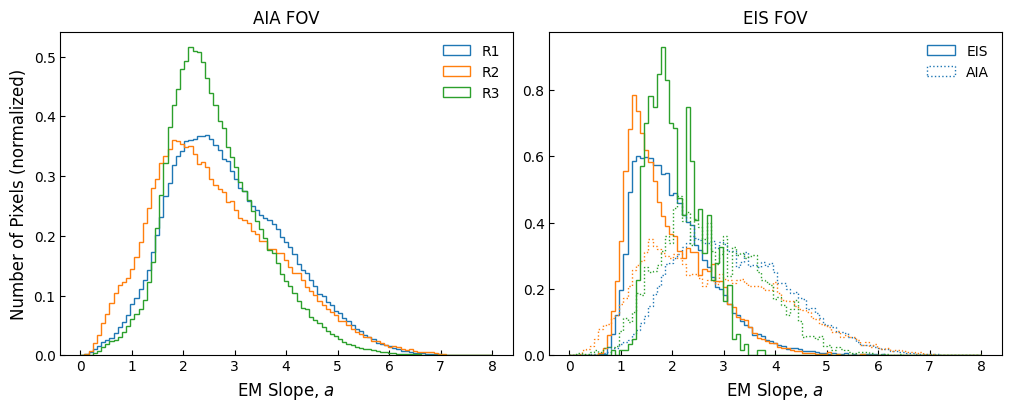

In [63]:
bins = np.linspace(0,8,100)
fig = plt.figure(figsize=(10,4),layout='constrained')
ax = fig.add_subplot(121)
for i,sm in enumerate(em_slopes_aia):
    combined_mask = np.any([sm.mask, flare_masks_aia[i]],axis=0)
    ax.hist(sm.data[~combined_mask],
            bins=bins,
            density=True,
            histtype='step',
            label=f'R{i+1}')
ax.set_xlabel('EM Slope, $a$')
ax.set_ylabel('Number of Pixels (normalized)')
ax.legend()
ax.set_title('AIA FOV')

ax = fig.add_subplot(122)
for i,(sme,sma) in enumerate(zip(em_slopes_eis,em_slopes_aia_eis_fov)):
    combined_mask = np.any([sme.mask, flare_masks_eis[i]],axis=0)
    ax.hist(sme.data[~combined_mask],
            bins=bins,
            density=True,
            histtype='step',
            label='EIS' if i==0 else None,
            color=f'C{i}')
    combined_mask = np.any([sma.mask, flare_masks_eis[i]],axis=0)
    ax.hist(sma.data[~combined_mask],
            bins=bins,
            density=True,
            histtype='step',
            ls=':',
            label='AIA' if i==0 else None,
            color=f'C{i}')
ax.set_xlabel('EM Slope, $a$')
ax.legend()
ax.set_title('EIS FOV')
fig.savefig(figure_dir / 'emslope_distribution.pdf')

## Time Lag Maps

In [64]:
selected_pairs = [
    '211_171',
    '193_171',
    '94_211',
    '335_193',
]

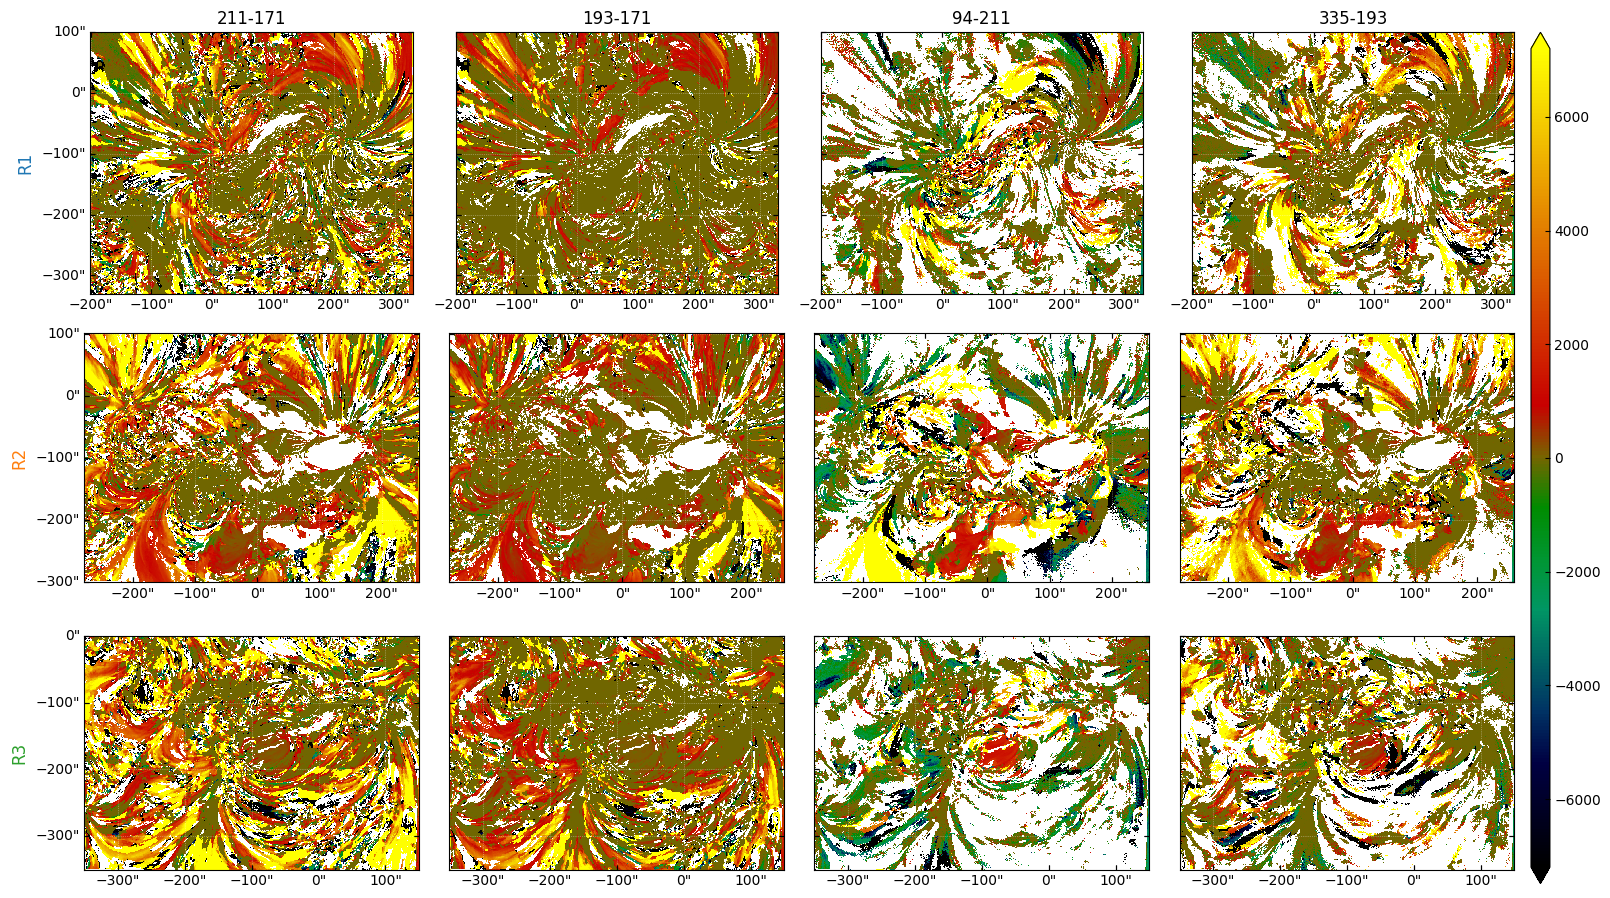

In [65]:
nr = len(tl_maps_aia)
nc = len(selected_pairs)
fig = plt.figure(figsize=(16,9), layout='constrained')
axes = []
for i,sp in enumerate(selected_pairs):
    _axes = []
    for j,(tld,row) in enumerate(zip(tl_maps_aia,ar_table)):
        _m = copy.deepcopy(tld[sp])
        _m.mask = np.any([_m.mask, flare_masks_aia[j]], axis=0)
        ax = fig.add_subplot(nr, nc, j*nc+i+1, projection=_m)
        im = _m.plot(axes=ax, cmap='idl_bgry_004', vmin=-7200, vmax=7200, annotate=False)
        ax.label_outer()
        ax.coords[0].set_auto_axislabel(False)
        ax.coords[1].set_auto_axislabel(False)
        if i > 0:
            ax.coords[1].set_ticklabel_visible(False)
        else:
            ax.coords[1].set_axislabel(f'R{j+1}', color=f'C{j}')
        if j == 0:
            ax.set_title('-'.join(sp.split('_')))
        #if j == nr-1:
        #    ax.coords[0].set_axislabel('HPC Longitude')
        _axes.append(ax)
    axes.append(_axes)
axes = np.array(axes).T
fig.colorbar(im, ax=axes[:,-1],
             orientation='vertical',
             location='right',
             fraction=1,
             extend='both',
             aspect=45,
             extendfrac=0.02)
fig.savefig(figure_dir / 'timelag_maps.pdf')

## Time Lag Distributions

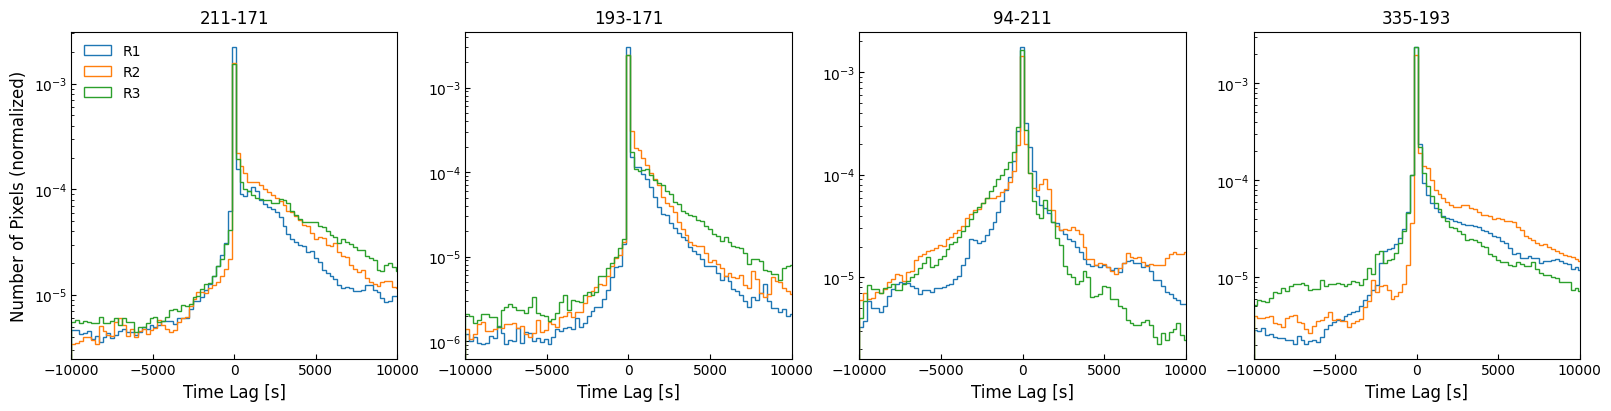

In [66]:
dt = 240
bin_lim = 1e4
bins = np.arange(-bin_lim,bin_lim+dt,dt)
fig,axes = plt.subplots(1,nc,figsize=(16,4), layout='constrained', sharex=True, sharey=False)
for j,(sp,ax) in enumerate(zip(selected_pairs,axes.flatten())):
    for i,(tld,row)in enumerate(zip(tl_maps_aia,ar_table)):
        _m = copy.deepcopy(tld[sp])
        ax.hist(_m.data[~np.any([_m.mask,flare_masks_aia[i]],axis=0)],
                histtype='step',
                density=True,
                log=True,
                label=f'R{i+1}',
                bins=bins)
    ax.set_title('-'.join(sp.split('_')))
    if j == 0:
        ax.legend(loc=2)
        ax.set_ylabel('Number of Pixels (normalized)')
    ax.set_xlabel('Time Lag [s]')
ax.set_xlim(-bin_lim,bin_lim)
fig.savefig(figure_dir / 'timelag_distribution.pdf')

## Correlations between slopes and time lags?

In [58]:
import matplotlib.colors

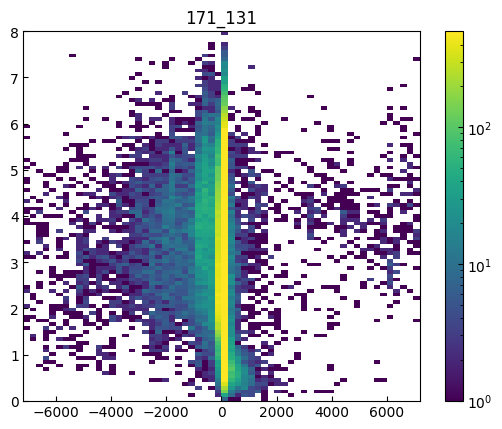

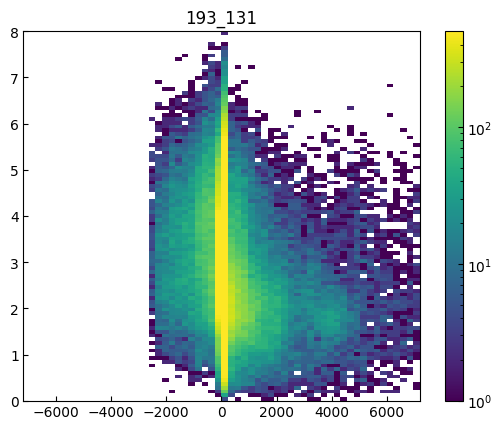

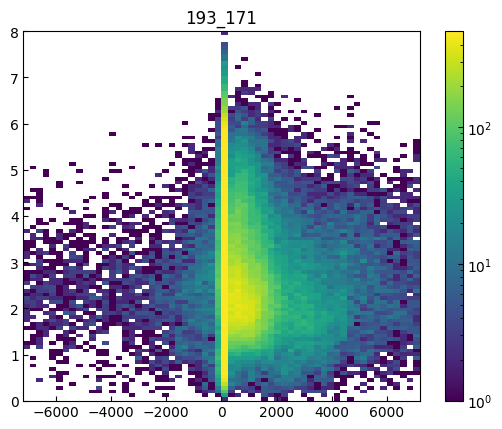

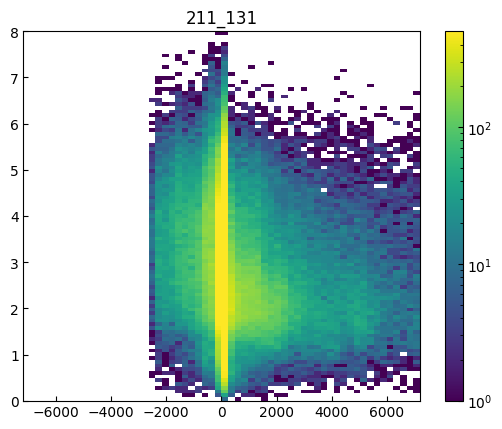

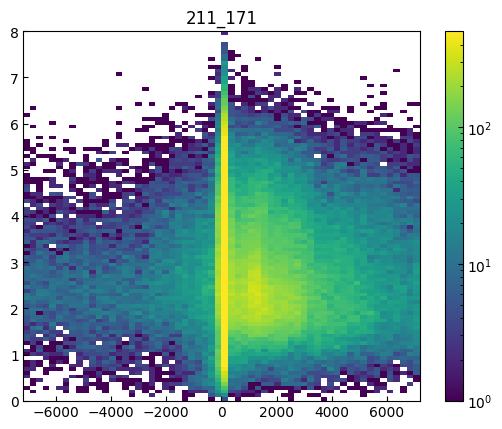

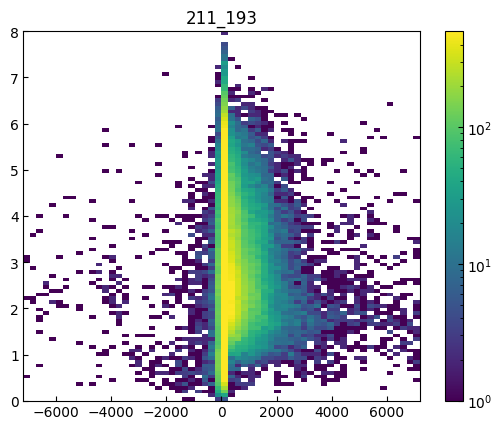

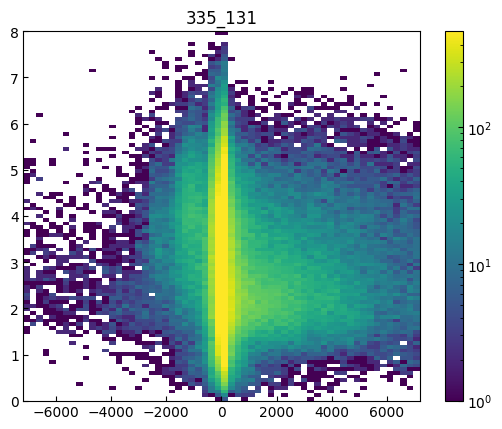

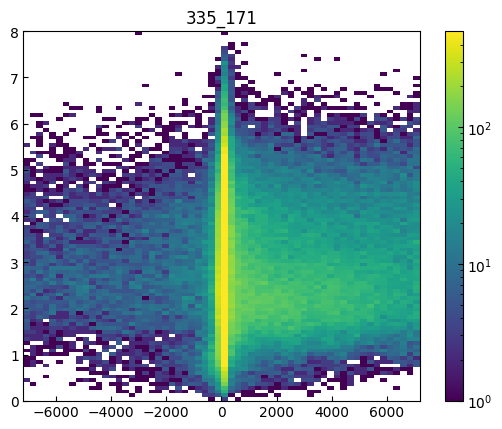

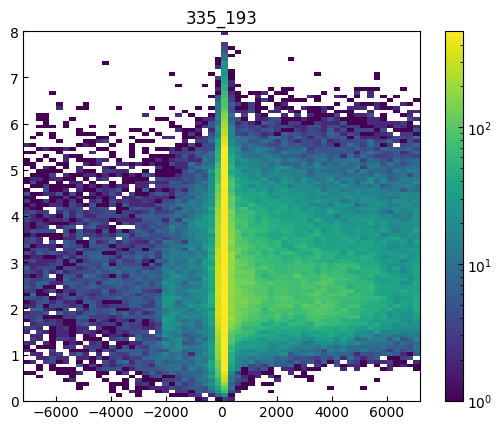

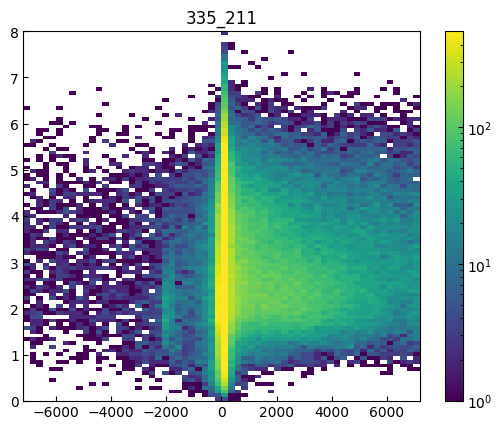

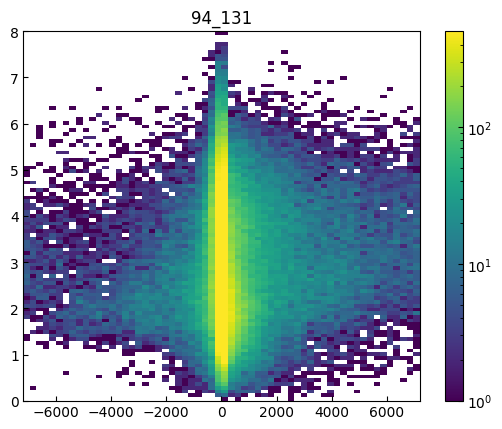

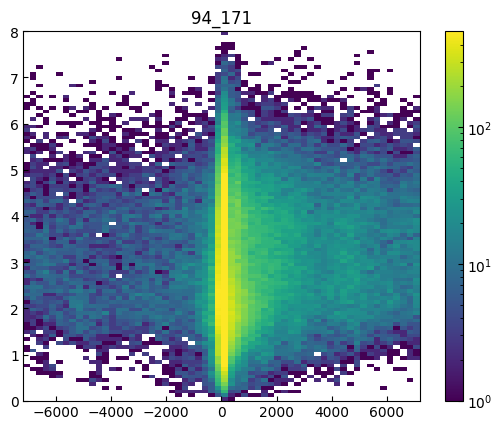

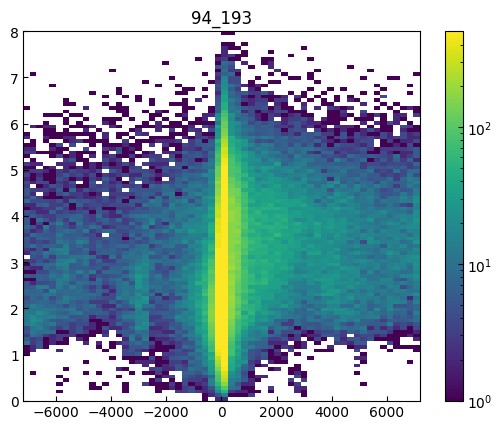

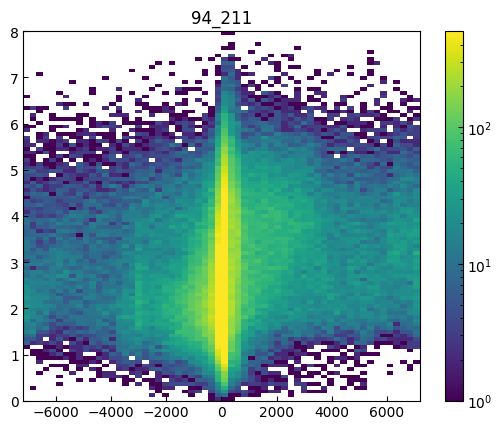

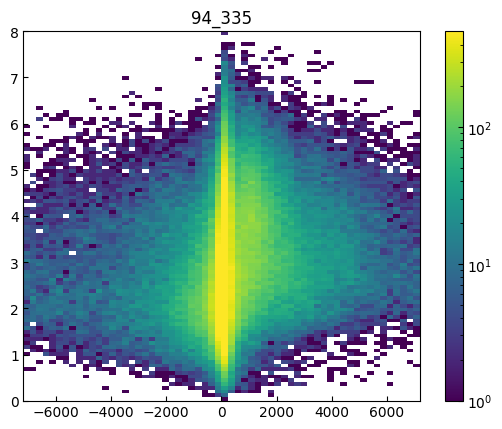

In [71]:
for sp in tl_maps_aia[0].keys():
    slope_tl_mask = np.any([em_slopes_aia[0].mask, tl_maps_aia[0][sp].mask, flare_masks_aia[0]],axis=0)
    slopes = em_slopes_aia[0].data[~slope_tl_mask]
    timelags = tl_maps_aia[0][sp].data[~slope_tl_mask]
    plt.figure()
    plt.hist2d(timelags,slopes,
               bins=(np.arange(-7200,7200+dt,dt),np.linspace(0,8,100)),
               norm=matplotlib.colors.LogNorm(vmax=5e2,vmin=1))
    plt.xlim(-7200,7200)
    plt.colorbar()
    plt.title(sp)
    plt.show()